In [1]:
import warnings

from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, execute

from qiskit.circuit.library import IntegerComparator

try:
    from aqua.components.uncertainty_models import GaussianConditionalIndependenceModel as GCI
    from aqua.components.uncertainty_problems import UnivariatePiecewiseLinearObjective as PwlObjective
    from aqua.components.uncertainty_problems import MultivariateProblem
    from aqua.circuits import WeightedSumOperator
    from aqua.algorithms import IterativeAmplitudeEstimation
    from aqua.utils.circuit_factory import CircuitFactory
except ModuleNotFoundError:
    warnings.warn("WARNING: Local Aqua 0.8.0 persistence package not found, using qiskit latest version.")
    from qiskit.aqua.components.uncertainty_models import GaussianConditionalIndependenceModel as GCI
    from qiskit.aqua.components.uncertainty_problems import UnivariatePiecewiseLinearObjective as PwlObjective
    from qiskit.aqua.components.uncertainty_problems import MultivariateProblem
    from qiskit.aqua.circuits import WeightedSumOperator
    from qiskit.aqua.algorithms import IterativeAmplitudeEstimation
    from qiskit.aqua.utils.circuit_factory import CircuitFactory
    
def warn(*args, **kwargs):
        pass
warnings.warn = warn

<ipython-input-1-5a53fdb50181>:15: UserWarning: WARNING: Local Aqua 0.8.0 persistence package not found, using qiskit latest version.
  warnings.warn("WARNING: Local Aqua 0.8.0 persistence package not found, using qiskit latest version.")


In [2]:
from qiskit import IBMQ, assemble, transpile, execute
from qiskit.providers.jobstatus import JOB_FINAL_STATES
from qiskit.providers.ibmq.job import IBMQJobFailureError
from qiskit.providers.ibmq import least_busy
from qiskit.aqua.algorithms import AmplitudeEstimation
from qiskit.aqua.algorithms import MaximumLikelihoodAmplitudeEstimation
from qiskit.circuit.library import LinearAmplitudeFunction

import numpy as np
import matplotlib.pyplot as plt

import pickle
import time
from datetime import datetime
import glob
import os

In [3]:
class Comparator(CircuitFactory):

    def __init__(self, num_state_qubits, value, geq=True, i_state=None, i_target=None):

        super().__init__(num_state_qubits + 1)
        self._comparator_circuit = IntegerComparator(value=value,
                                                     num_state_qubits=num_state_qubits,
                                                     geq=geq)

        self.i_state = None
        if i_state is not None:
            self.i_state = i_state
        else:
            self.i_state = range(num_state_qubits)

        self.i_target = None
        if i_target is not None:
            self.i_target = i_target
        else:
            self.i_target = num_state_qubits

    @property
    def num_state_qubits(self):
        """ returns num state qubits """
        return self._comparator_circuit._num_state_qubits

    @property
    def value(self):
        """ returns value """
        return self._comparator_circuit._value

    def required_ancillas(self):
        return self.num_state_qubits - 1

    def required_ancillas_controlled(self):
        return self.num_state_qubits - 1


    def _get_twos_complement(self):
        """Returns the 2's complement of value as array

        Returns:
             list: two's complement
        """

        twos_complement = pow(2, self.num_state_qubits) - int(np.ceil(self.value))
        twos_complement = '{0:b}'.format(twos_complement).rjust(self.num_state_qubits, '0')
        twos_complement = \
            [1 if twos_complement[i] == '1' else 0 for i in reversed(range(len(twos_complement)))]
        return twos_complement

    def build(self, qc, q, q_ancillas=None, params=None):
        instr = self._comparator_circuit.to_instruction()
        qr = [q[i] for i in self.i_state] + [q[self.i_target]]
        if q_ancillas:
            # pylint:disable=unnecessary-comprehension
            qr += [qi for qi in q_ancillas[:self.required_ancillas()]]
        qc.append(instr, qr)

IMPLEMENTED_ALGORITHMS = ['iqae','ae','mlae']
        
class CreditRiskAnalysis:
    def __init__(self,p_zeros,rhos,lgd,backend=None,shots=1024,n_z=2,z_max=2,alpha=0.05,epsilon=0.01, num_ml_queries = 5 ,ae_algorithm = 'iqae', num_eval_qubits=5):
        
        if backend is None:
            backend = Aer.get_backend('statevector_simulator')
            
        self.backend_name = backend.name()
        self.backend = backend
        self.sim = ('simulator' in self.backend_name)
        self.statevector = ('statevector' in self.backend_name)
        
        if ae_algorithm.lower() not in IMPLEMENTED_ALGORITHMS:
            raise ValueError("CreditRiskAnalysis class needs an AE Algorithm between the following: "+ str(IMPLEMENTED_ALGORITHMS))

        self.ae_algorithm = ae_algorithm.lower()
        
        self.p_zeros = p_zeros
        self.rhos = rhos
        self.lgd = lgd
        self.z_values = np.linspace(-z_max, z_max, 2**n_z)
        self.n_z = n_z
        self.z_max = z_max
        self.K = len(p_zeros)
        self.alpha = alpha
        self.epsilon = epsilon
        self.shots = shots
        self.num_eval_qubits = num_eval_qubits
        self.num_ml_queries = num_ml_queries
        self.job = None
        self.qc = None
        
        # set plot style to seaborn
        plt.style.use("seaborn")
        
    def is_sim(self):
        return self.sim
    
    def draw_qc(self):
        return self.qc.draw()
    
    def save_job(self):
        if hasattr(self,'qae_result'):
            self.job.qae_result = self.qae_result
        backend_name = self.job.result().backend_name
        date = date.today().strftime("%m-%d-%Y_%H.%M")
        pickle.dump( result, open("ibmq_results/"+date+"_"+'job'+"_"+backend_name+".p", "wb" ) )
    
    def load_job(self,name):
        self.job = pickle.load( open("ibmq_results/"+name, "rb") )
        
    def load_last_job(self):
        list_of_files = glob.glob('ibmq_results/*.p')
        latest_file = max(list_of_files, key=os.path.getctime)
        self.load_job(latest_file)
        
    def execute_ibmq(self):
        job = execute(self.qc,backend=self.backend,shots=self.shots)
        start_time = time.time()
        job_status = job.status()
        print('Executing QC in backend '+self.backend_name+'...')
        while job_status not in JOB_FINAL_STATES:
            print('\r'+' '*60+'\r', end='')
            print(f'Status @ {time.time()-start_time:0.0f} s: {job_status.name},'
                  f' est. queue position: {job.queue_position()}', end="")
            time.sleep(1)
            job_status = job.status()
        try:
            print('')
            job.result()
            print('Done!')
        except IBMQJobFailureError:
            print('Error: ' + job.error_message())
        return job
    
    def build_U(self):
        # construct circuit factory for uncertainty model (Gaussian Conditional Independence model)
        self.u = GCI(self.n_z, self.z_max, self.p_zeros, self.rhos)
        # determine the number of qubits required to represent the uncertainty model
        self.num_qubits = self.u.num_target_qubits

        # initialize quantum register and circuit
        q = QuantumRegister(self.num_qubits, name='q')
        self.qc = QuantumCircuit(q)

        # construct circuit
        self.u.build(self.qc, q)
    
    def run_U(self):
        if not hasattr(self,'u'):
            self.build_U()
        if self.is_sim():
            if not self.statevector:
                self.qc.measure_all()
                self.job = execute(self.qc,backend=self.backend,shots=self.shots)
            else:
                self.job = execute(self.qc,backend=self.backend)
        else:
            self.qc.measure_all()
            self.job = self.execute_ibmq()
            
    def compute_U(self):
        self.run_U()
        self.p_z = np.zeros(2**self.n_z)
        self.p_default = np.zeros(self.K)
        values = []
        probabilities = []
        K = self.K
        
        if self.statevector:
            for i, a in enumerate(self.job.result().get_statevector()):
                # get binary representation
                b = ('{0:0%sb}' % self.num_qubits).format(i) # transforma i en una cadena de ceros y unos (como es de esperar)
                prob = np.abs(a)**2 # dicha cadena tiene una amplitud a, que sabemos que al cuadrado es la probabilidad
                                    # de medirse

                # extract value of Z and corresponding probability    
                i_normal = int(b[-self.n_z:], 2) # los n_z ultimos bits son el resultado de la normal, que se castean en base 2
                self.p_z[i_normal] += prob       # a dicho valor de la normal le corresponde añadir cierta probabilidad

                # determine overall default probability for k 
                loss = 0
                for k in range(K):
                    if b[K - k - 1] == '1':   # si el asset correspondiente tiene pérdida en dicho posible resultado (b)
                        self.p_default[k] += prob  # se aumenta en su probabilidad de pérdida
                        loss += self.lgd[k]        # y se suma dicha pérdida potencial
                values += [loss]
                probabilities += [prob]   
        else:
            for b,a in self.job.result().get_counts().items():
                prob = a/self.shots
                # extract value of Z and corresponding probability    
                i_normal = int(b[-self.n_z:], 2) # los n_z ultimos bits son el resultado de la normal, que se castean en base 2
                self.p_z[i_normal] += prob       # a dicho valor de la normal le corresponde añadir cierta probabilidad
                # determine overall default probability for k 
                loss = 0
                for k in range(self.K):
                    if b[K - k - 1] == '1':   # si el asset correspondiente tiene pérdida en dicho posible resultado (b)
                        self.p_default[k] += prob  # se aumenta en su probabilidad de pérdida
                        loss += self.lgd[k]        # y se suma dicha pérdida potencial
                values += [loss]
                probabilities += [prob] 
        
        self.values = np.array(values)
        self.probabilities = np.array(probabilities)
        
        self.expected_loss = np.dot(self.values, self.probabilities) # es un producto escalar como es de esperar

        self.losses = range(0,sum(self.lgd)+1)
        pdf = np.zeros(len(self.losses))
        for i, v in enumerate(self.losses):
            pdf[i] += sum(self.probabilities[self.values == v]) # funcion de distribución de probabilidad
        self.pdf = pdf
        self.cdf = np.cumsum(self.pdf)
        
        i_var = np.argmax(self.cdf >= 1-self.alpha)  # calculando el indice que da el VaR
        self.exact_var = self.losses[i_var] # el VaR
        self.exact_cvar = np.dot(self.pdf[(i_var+1):], self.losses[(i_var+1):])/sum(self.pdf[(i_var+1):]) # CVaR
        self.i_var = i_var

        return self.num_qubits, self.losses, self.expected_loss, self.exact_var, self.exact_cvar, self.pdf, self.p_z, self.p_default


    def print_U(self):
        if not hasattr(self,"i_var"):
            self.compute_U()
            
        print('------------ RESULTS OF U IN \"'+self.backend_name+'\" ------------')
        print('Expected Loss E[L]:                        %.8f' % self.expected_loss)
        print('Value at Risk VaR[L]:                      %.8f' % self.exact_var)
        print('P[L <= VaR[L]]:                            %.8f' % self.cdf[self.i_var])
        
        
    def graph_U(self):
        self.print_U()
        
        # plot loss PDF, expected loss, var, and cvar
        plt.bar(self.losses, self.pdf)
        plt.axvline(self.expected_loss, color='green', linestyle='--', label='E[L]')
        plt.axvline(self.exact_var, color='orange', linestyle='--', label='VaR(L)')
        plt.legend(fontsize=15)
        plt.xlabel('Loss L ($)', size=15)
        plt.ylabel('probability (%)', size=15)
        plt.title('Loss Distribution ('+self.backend_name+')', size=20)
        plt.xticks(size=15)
        plt.yticks(size=15)
        plt.show()

        # plot results for Z
        plt.plot(self.z_values, self.p_z, 'o-', linewidth=3, markersize=8)
        plt.grid()
        plt.xlabel('Z value', size=15)
        plt.ylabel('probability (%)', size=15)
        plt.title('Z Distribution ('+self.backend_name+')', size=20)
        plt.xticks(size=15)
        plt.yticks(size=15)
        plt.show()

        # plot results for default probabilities
        w = 0.4
        plt.bar(range(self.K), self.p_default, align="edge", width=w)
        plt.bar(range(self.K), self.p_zeros, align="edge", width=-w)
        plt.xlabel('Asset', size=15)
        plt.ylabel('probability (%)', size=15)
        plt.title('Individual Default Probabilities ('+self.backend_name+')', size=20)
        plt.xticks(range(self.K), size=15)
        plt.yticks(size=15)
        plt.grid()
        plt.legend(["Simulated Probabilities",r"Initial Probabilities ($p_0$)"])
        plt.show()
        
    def graph_main(self,e=False,var=False):
        # plot loss PDF, expected loss, var, and cvar
        plt.bar(self.losses, self.pdf)
        plt.axvline(self.expected_loss, color='green', linestyle='--', label='E[L]')
        
        var_line = '-' if var and (self.var == self.exact_var) else '--'
        
        plt.axvline(self.exact_var, color='orange', linestyle=var_line, label='VaR(L)')
        
        if e:
            plt.axvline(self.estimated_expected_loss, color='lime', linestyle='--', label='Est. E[L]')
        if var:
            est_var_line = (0, (10, 10)) if (self.var == self.exact_var) else '--'
            plt.axvline(self.var, color='red', linestyle=est_var_line, label='Est. VaR(L)')
        plt.legend(fontsize=15)
        plt.xlabel('Loss L ($)', size=15)
        plt.ylabel('probability (%)', size=15)
        plt.title('Loss Distribution ('+self.backend_name+')', size=20)
        plt.xticks(size=15)
        plt.yticks(size=15)
        plt.show()
        
    def build_E(self):
        # determine number of qubits required to represent total loss
        self.n_s = WeightedSumOperator.get_required_sum_qubits(self.lgd)

        # create circuit factory (add Z qubits with weight/loss 0)
        self.agg = WeightedSumOperator(self.n_z + self.K, [0]*self.n_z + self.lgd) # se añaden los qubits que se utilizaban para Z
        
        breakpoints = [0]
        slopes = [1]
        offsets = [0]
        f_min = 0
        f_max = sum(self.lgd)
        c_approx = 0.25

        objective = PwlObjective(
            self.agg.num_sum_qubits, # n de qubits necesarios
            0,                  # minimo valor que se introduce en la funcion
            2**self.agg.num_sum_qubits-1,  # max value that can be reached by the qubit register (will not always be reached)
            breakpoints,        # puntos de cambio
            slopes,             # pendientes de cada segmento lineal (e.d, a en ax + b)
            offsets,            # desviación de cada segmento (e.d, b en ax + b)
            f_min,              # minimo valor de la funcion
            f_max,              # maximo valor de la funcion
            c_approx            # un factor de aproximacion, que da lugar a "comprimir" los segmentos con rotaciones pi/4
        )

#        objective = LinearAmplitudeFunction(
#            self.agg.num_sum_qubits,
#            slope=slopes,
#            offset=offsets,
#            domain=(0,2**self.agg.num_sum_qubits-1),
#            image=(f_min,f_max),
#            rescaling_factor=c_approx,
#            breakpoints=breakpoints
#        )

        if not hasattr(self,'u'):
            self.compute_U()
        # define overall multivariate problem
        self.multivariate = MultivariateProblem(self.u, self.agg, objective) # Esto es A en el paper: U, S y "C" (aún no)

        self.num_qubits = self.multivariate.num_target_qubits
        self.num_ancillas = self.multivariate.required_ancillas()

        q = QuantumRegister(self.num_qubits, name='q')
        q_a = QuantumRegister(self.num_ancillas, name='q_a')
        if not self.statevector:
            q_c = ClassicalRegister(self.num_qubits, name='c')
            self.qc = QuantumCircuit(q, q_a, q_c)
            self.q_c = q_c
            self.q = q
        else:
            self.qc = QuantumCircuit(q, q_a)

        self.multivariate.build(self.qc, q, q_a)
    
    def run_E(self):
        if not hasattr(self, 'multivariate'):
            self.build_E()
        if self.statevector:
            self.job = execute(self.qc,backend=self.backend)
        else:
            self.qc.measure(self.q,self.q_c)
            if not self.is_sim():
                self.job = self.execute_ibmq()
                self.save_job()
            else:
                self.job = execute(self.qc,backend=self.backend,shots=self.shots)
    
    def print_E(self):
        self.run_E()
        self.value = 0
        
        if self.statevector:
            for i, a in enumerate(self.job.result().get_statevector()):
                b = ('{0:0%sb}' % self.multivariate.num_target_qubits).format(i)[-self.multivariate.num_target_qubits:]
                am = np.round(np.real(a), decimals=4)
                if np.abs(am) > 1e-6 and b[0] == '1':
                    self.value += am**2
        else:
            for b, a in self.job.result().get_counts().items():
                b = b[-self.multivariate.num_target_qubits:]
                am = np.round(np.real(a/self.shots), decimals=4)
                if np.abs(am) > 1e-6 and b[0] == '1':
                    self.value += am**2

        print('\n------------ RESULTS OF E IN \"'+self.backend_name+'\" ------------')
        if hasattr(self, 'expected_loss'):
            print('Exact Expected Loss:   %.4f' % self.expected_loss) 
        else:
            print('(Call \'print_U\' for exact expected loss)')
        print('Exact Operator Value:  %.4f' % self.value)
        print('Mapped Operator value: %.4f' % self.multivariate.value_to_estimation(self.value))

    def print_qae_E(self):
        if not hasattr(self, 'multivariate'):
            self.build_E()

        # construct amplitude estimation
        if not self.is_sim():
            print('Executing' + self.ae_algorithm + 'for E in backend ' + self.backend_name + '...')
        
        if self.ae_algorithm == 'iqae':
            self.ae = IterativeAmplitudeEstimation(epsilon=self.epsilon, alpha=self.alpha, a_factory=self.multivariate)
        elif self.ae_algorithm == 'mlae':
            self.ae = MaximumLikelihoodAmplitudeEstimation(self.num_ml_queries,a_factory=self.multivariate)
        else:
            self.ae = AmplitudeEstimation(self.num_eval_qubits, self.multivariate)
        
        self.qae_result = self.ae.run(quantum_instance=self.backend, shots=self.shots)
        
        self.estimated_expected_loss = self.qae_result['estimation']
        
        # print results
        self.conf_int = np.array(self.qae_result['confidence_interval'])
        print('\n----- RESULTS OF ' + self.ae_algorithm.upper() + ' FOR E IN \"'+self.backend_name+'\" -----')
        if hasattr(self,'expected_loss'):
            print('Exact value:    \t\t%.8f' % self.expected_loss)
        else:
            print('(Call \'print_U\' for exact expected loss)')
        print('Estimated value:\t\t%.8f' % self.estimated_expected_loss)
        print('Confidence interval: \t\t[%.8f, %.8f]' % tuple(self.conf_int))

        return self.expected_loss, self.qae_result['estimation'], self.ae.q_factory.get_num_qubits()
    
    def graph_E(self):
        self.print_qae_E()

        a = self.qae_result['confidence_interval'][0]
        b = self.qae_result['confidence_interval'][1]
        x_min = min(a,self.expected_loss)*0.9
        x_max = max(b,self.expected_loss)*1.1
        
        # plot estimated values for expected loss (after re-scaling and reversing the c_approx-transformation)
        qae_loss = self.qae_result['estimation']
        plt.bar(qae_loss, 1-self.alpha, width=b-a,color="lightsteelblue")
        plt.bar(qae_loss, 1-self.alpha, width=0.1*(b-a))
        if hasattr(self,'expected_loss'):
            plt.axvline(self.expected_loss, color='red', linestyle='--', linewidth=2)
        plt.xticks(np.round(np.linspace(x_min,x_max,8)*1000)/1000,size=15)
        plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
        plt.title('Expected Loss ('+self.backend_name+')', size=15)
        plt.ylabel('Probability', size=15)
        plt.ylim((0,1))
        plt.grid()
        plt.legend(["Exact Result", "Confidence Interval", "Estimated Result"])
        plt.show()
        
        self.graph_main(e=True)
        
    
    # define value x to evaluate the CDF(x)
    def get_cdf_operator_factory(self,x_eval):
        if not hasattr(self, 'agg'):
            self.build_E()
        # comparator as objective
        # cdf_objective = Comparator(agg.num_sum_qubits, x_eval+1, geq=False) # Con Comparator creamos C
        cdf_objective = Comparator(self.agg.num_sum_qubits, x_eval+1, geq=False) # Con Comparator creamos C

        # define overall uncertainty problem
        multivariate_cdf = MultivariateProblem(self.u, self.agg, cdf_objective) # A: U, S y C

        return multivariate_cdf
    
    def build_cdf(self,x_eval):
        # get operator
        multivariate_cdf = self.get_cdf_operator_factory(x_eval) # crea A

        # get required number of qubits
        self.num_qubits = multivariate_cdf.num_target_qubits
        self.num_ancillas = multivariate_cdf.required_ancillas()  # TODO: why do we need two more ancillas? (Creo que es para las sumar que implementan el comparador)

        # construct circuit
        q = QuantumRegister(self.num_qubits, name='q')
        q_a = QuantumRegister(self.num_ancillas, name='q_a')
        if not self.is_sim():
            q_c = ClassicalRegister(self.num_qubits, name='c')
            self.qc = QuantumCircuit(q, q_a, q_c)
            self.q_c = q_c
            self.q = q
        else:
            self.qc = QuantumCircuit(q, q_a)
        
        multivariate_cdf.build(self.qc, q, q_a)
        
        self.multivariate_cdf = multivariate_cdf
        
    def run_cdf(self,x_eval):
        if not hasattr(self, 'multivariate_cdf'):
            self.build_cdf(x_eval)
        if self.is_sim():
            self.job = execute(self.qc,backend=self.backend)
            self.save_job()
        else:
            self.qc.measure(self.q,self.qc)
            self.job = self.execute_ibmq()
    
    def print_cdf(self,x_eval):
        self.run_cdf(x_eval)
        self.var_prob = 0
        if self.statevector:
            for i, a in enumerate(self.job.result().get_statevector()):
                b = ('{0:0%sb}' % self.multivariate_cdf.num_target_qubits).format(i)[-self.multivariate_cdf.num_target_qubits:]
                prob = np.abs(a)**2
                if prob > 1e-6 and b[0] == '1':
                    self.var_prob += prob
        else:
            for b, a in self.job.result().get_counts().items():
                prob = np.round(np.real(a/self.shots), decimals=4)
                if prob > 1e-6 and b[0] == '1':
                    self.var_prob += prob

        print('\n----- RESULTS OF CDF IN \"'+self.backend_name+'\" -----')
        print('Operator CDF(%s)' % x_eval + ' = %.8f' % self.var_prob)
        if hasattr(self,'cdf'):
            print('Exact    CDF(%s)' % x_eval + ' = %.8f' % self.cdf[x_eval])
        else:
            print('(Call \'print_U\' for exact cdf)')
    
        
    def run_qae_cdf(self, x_eval):
        self.build_cdf(x_eval)
        if not self.is_sim():
            print('Executing '+ self.ae_algorithm + ' for CDF('+str(x_eval)+') in backend ' + self.backend_name + '...')
            
        if self.ae_algorithm == 'iqae':
            self.ae_cdf = IterativeAmplitudeEstimation(epsilon=self.epsilon, alpha=self.alpha, a_factory=self.multivariate_cdf)
        elif self.ae_algorithm == 'mlae':
            self.ae_cdf = MaximumLikelihoodAmplitudeEstimation(self.num_ml_queries,a_factory=self.multivariate_cdf)
        else:
            self.ae_cdf = AmplitudeEstimation(self.num_eval_qubits, self.multivariate_cdf)
        
        self.qae_result = self.ae_cdf.run(quantum_instance=self.backend, shots=self.shots)
        
        return self.qae_result
        
    def graph_qae_cdf(self,x_eval):
        self.run_qae_cdf(x_eval)
        # print results
        print('\n----- RESULTS OF ' + self.ae_algorithm.upper() + ' FOR CDF IN \"'+self.backend_name+'\" -----')
        if hasattr(self,'cdf'):
            print('Exact    CDF(%s)' % x_eval + ' = %.8f' % self.cdf[x_eval])
        else:
            print('(Call \'print_U\' for exact cdf)')
        print('Estimated value:\t%.8f' % self.qae_result['estimation'])
        print('Probability:    \t%.4f' % (1-self.alpha))

        # plot estimated values for "a"
        plt.bar(self.qae_result['estimation'], 1-self.alpha, width=0.05)
        if hasattr(self,'cdf'):
            plt.axvline(self.cdf[x_eval], color='red', linestyle='--', linewidth=2)
        plt.xticks([0, 0.25, 0.5, 0.75, 1],size=15)
        plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
        plt.title(('CDF(%s)' % x_eval)+' ('+self.backend_name+')', size=15)
        plt.ylabel('Probability', size=15)
        plt.ylim((0,1))
        plt.grid()
        plt.show()
        
    def ks_test(self, qae_cdf):
        self.delta = np.max(np.absolute(np.array(self.cdf) - np.array(qae_cdf)))
        n = len(self.cdf)
        
        # p_value is obtained by inverting the C(alpha) formula for n=m
        # https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Two-sample_Kolmogorov%E2%80%93Smirnov_test
        self.p_value = np.e**(-n*self.delta**2)
        
        print(f'--- CDF Kolmogorov-Smirnov test using {self.ae_algorithm} ----')
        print('Delta value: %.5f' %  self.delta)
        print('P-value (alpha = %.4f): %.5f' % (self.alpha,self.p_value))
        
    def graph_cdf(self):
        results = [ self.run_qae_cdf(x) for x in range(0,sum(self.lgd)+1) ]
        
        print(f'--- CDF Original values using {self.ae_algorithm} in {self.backend}')
        for x,y in enumerate([(r['estimation'],r['confidence_interval']) for r in results]):
            print(f"\t CDF({x}) = {y[0]}, CI: {y[1]}")
        
        qae_cdf = np.maximum.accumulate([ r['estimation'] for r in results])
        conf_int_low = np.maximum.accumulate([ r['confidence_interval'][0] for r in results])
        conf_int_high = np.maximum.accumulate([ r['confidence_interval'][1] for r in results])
        
        qae_cdf[-1], conf_int_low[-1], conf_int_high[-1] = 1, 1, 1
        
        self.ks_test(qae_cdf)
        
        x = range(0,sum(self.lgd)+1)
        max_x = x[-1]
        plt.fill_between(x, conf_int_high, conf_int_low, color='lightsteelblue')
        plt.plot(x,qae_cdf,'o-',markersize=4,linewidth=0.5)
        plt.plot(x,self.cdf,'--',color='orange')
        plt.axhline(1-self.alpha, color='red', linestyle='--',linewidth=2)
        
        min_y = min(conf_int_low[0],self.cdf[0]) * 0.90
        
        plt.ylabel('Probability', size=15)
        plt.ylim((min_y,1.05))
        plt.xlabel('Loss ($)', size=15)

        plt.annotate('Delta value: %.5f' %  self.delta, xy=(0, 0), xycoords='axes fraction',
                     xytext=(3, 20), textcoords='offset pixels',size=13)
        plt.annotate('P-value (alpha = %d%%): %.5f' % (self.alpha*100,self.p_value),xy=(0, 0),
                     xycoords='axes fraction',
                     xytext=(3, 5), textcoords='offset pixels',size=13) 
        
        plt.title(f'CDF using {self.ae_algorithm}', size=15)
        plt.legend(['Estimated CDF','Exact CDF',f'Alpha level ({(1-self.alpha)*100}%)','Confidence Interval'])
        
        plt.show()
    
    def run_ae_for_cdf(self,x_eval):

        # run amplitude estimation
        multivariate_var = self.get_cdf_operator_factory(x_eval)
        if not self.is_sim():
            print('Executing '+ self.ae_algorithm + ' for CDF('+str(x_eval)+') in backend ' + self.backend_name + '...')
        
        if self.ae_algorithm == 'iqae':
            self.ae_var = IterativeAmplitudeEstimation(epsilon=self.epsilon, alpha=self.alpha, a_factory=multivariate_var)
        elif self.ae_algorithm == 'mlae':
            self.ae_var = MaximumLikelihoodAmplitudeEstimation(self.num_ml_queries,a_factory=multivariate_var)
        else:
            self.ae_var = AmplitudeEstimation(self.num_eval_qubits,a_factory = multivariate_var)
        
        result_var = self.ae_var.run(self.backend)
        self.qae_result = result_var

        return result_var['estimation']
    
    def bisection_search(self,objective, target_value, low_level, high_level, low_value=None, high_value=None, verbose=True):
        """
        Determines the smallest level such that the objective value is still larger than the target
        :param objective: objective function
        :param target: target value
        :param low_level: lowest level to be considered
        :param high_level: highest level to be considered
        :param low_value: value of lowest level (will be evaluated if set to None)
        :param high_value: value of highest level (will be evaluated if set to None)
        :return: dictionary with level, value, num_eval
        """

        # check whether low and high values are given and evaluated them otherwise
        if verbose:
            print('\n--------------------------------------------------------------------')
            print('start bisection search for target value %.3f' % target_value)
            print('--------------------------------------------------------------------')
        num_eval = 0
        if low_value is None:
            low_value = objective(low_level)
            num_eval += 1
        if high_value is None:
            high_value = objective(high_level)
            num_eval += 1    

        levels = []
        values = []
            
        # check if low_value already satisfies the condition
        if low_value > target_value:
            return {'level': low_level, 'value': low_value, 'num_eval': num_eval, 'comment': 'returned low value'}
        elif low_value == target_value:
            return {'level': low_level, 'value': low_value, 'num_eval': num_eval, 'comment': 'success'}

        # check if high_value is above target
        if high_value < target_value:
            return {'level': high_level, 'value': high_value, 'num_eval': num_eval, 'comment': 'returned low value'}
        elif high_value == target_value:
            return {'level': high_level, 'value': high_value, 'num_eval': num_eval, 'comment': 'success'}

        # perform bisection search until
        if verbose:
            print('low_level    low_value    level    value    high_level    high_value')
            print('--------------------------------------------------------------------')
        while high_level - low_level > 1:

            level = int(np.round((high_level + low_level) / 2.0))
            num_eval += 1
            value = objective(level)

            values.append(value)
            levels.append(level)
            
            if verbose:
                print('%2d           %.3f        %2d       %.3f    %2d            %.3f' \
                      % (low_level, low_value, level, value, high_level, high_value))

            if value >= target_value:
                high_level = level
                high_value = value
            else:
                low_level = level
                low_value = value

        # return high value after bisection search
        if verbose:
            print('--------------------------------------------------------------------')
            print('finished bisection search')
            print('--------------------------------------------------------------------')
        return {'level': high_level, 'value': high_value, 'num_eval': num_eval, 'comment': 'success'}, values, levels

    def run_var(self, verbose=True):
        if not hasattr(self,"losses"):
            self.compute_U()
        objective = lambda x: self.run_ae_for_cdf(x)
        bisection_result,self.var_values,self.var_levels = self.bisection_search(objective, 1-self.alpha, min(self.losses)-1, max(self.losses), low_value=0, high_value=1,verbose=verbose)
        self.var = bisection_result['level']
        self.var_prob = bisection_result['value']
        
    def print_var(self,verbose=True):
        if not hasattr(self,"var"):
            self.run_var(verbose=verbose)
            
        print('\n----- RESULTS OF ' + self.ae_algorithm.upper() + ' FOR VaR IN \"'+self.backend_name+'\" -----')
        print('Estimated Value at Risk: %2d' % self.var)
        print('Exact Value at Risk:     %2d' % self.exact_var)
        print('Estimated Probability:    %.8f' % self.var_prob)
        print('Exact Probability:        %.8f' % self.cdf[self.i_var])
    
    def graph_var(self, verbose=True):
        if not hasattr(self,"var"):
            self.run_var(verbose=verbose)
        plt.plot(self.var_levels,self.var_values,'o-',linewidth=3,markersize=3)
        plt.axhline(1-self.alpha,color='red',linestyle='--', linewidth=2)
        plt.plot(self.exact_var,self.cdf[self.i_var],'^',markersize=9)
        plt.plot(self.var,self.var_prob,'v',markersize = 9)
        
        i = 0
        for x,y in zip(self.var_levels,self.var_values):
            i += 1
            plt.text(x+0.05,y+0.001,f"{i}",fontsize="large")
        
        plt.title('VaR Bisection Search ('+self.backend_name+')', size=15)
        plt.ylabel('Probability', size=15)
        plt.legend(["Bisection search progress",f"Confidence value ({(1-self.alpha)*100}%)","Exact VaR", "Estimated VaR"])
        plt.show()
        
        self.graph_main(e=hasattr(self,"estimated_expected_loss"),var=True)
        
    def run_all(self):
        self.graph_U()
        self.graph_E()
        self.graph_cdf()
        self.print_var()
        self.graph_var()


In [4]:
simulation = False
csic = True

if simulation:
    backend = Aer.get_backend('qasm_simulator')
else:
    Backend_qubits = 7
    IBMQ.load_account()
    if csic:
        provider = IBMQ.get_provider(hub='ibm-q-csic')
        provider.backends()
    else:
        provider = IBMQ.load_account()
    from qiskit.providers.ibmq import least_busy
    # backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= Backend_qubits and not b.configuration().simulator and b.status().operational==True))
    backend = provider.get_backend("ibmq_toronto")
    print ("Backend:", backend)
    

Backend: ibmq_toronto


Executing QC in backend ibmq_toronto...
Status @ 389 s: RUNNING, est. queue position: None          
Done!
------------ RESULTS OF U IN "ibmq_toronto" ------------
Expected Loss E[L]:                        0.66113281
Value at Risk VaR[L]:                      2.00000000
P[L <= VaR[L]]:                            0.98339844


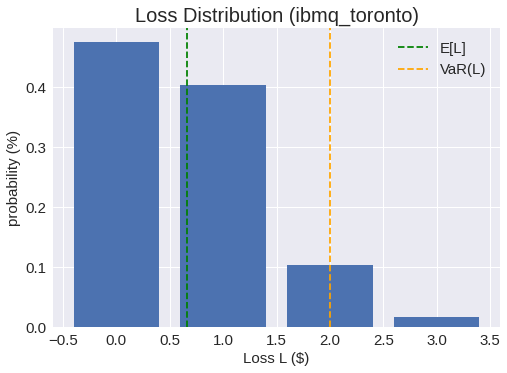

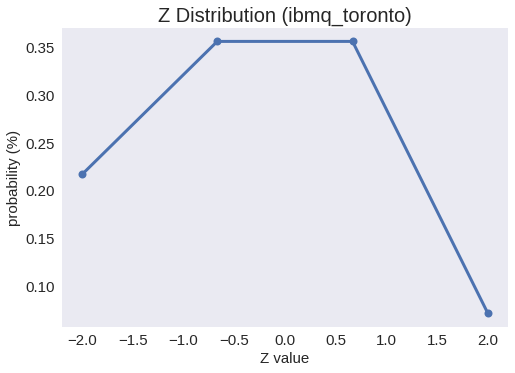

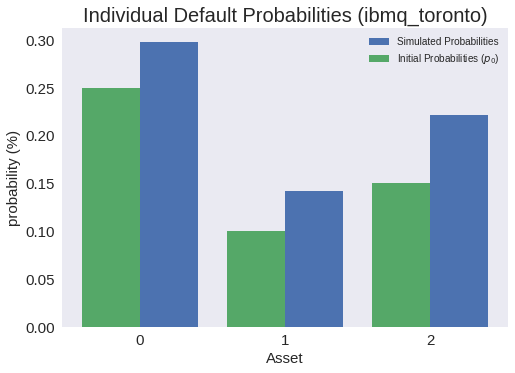

Executingmlaefor E in backend ibmq_toronto...

----- RESULTS OF MLAE FOR E IN "ibmq_toronto" -----
Exact value:    		0.66113281
Estimated value:		1.42797731
Confidence interval: 		[1.42192562, 1.43402901]


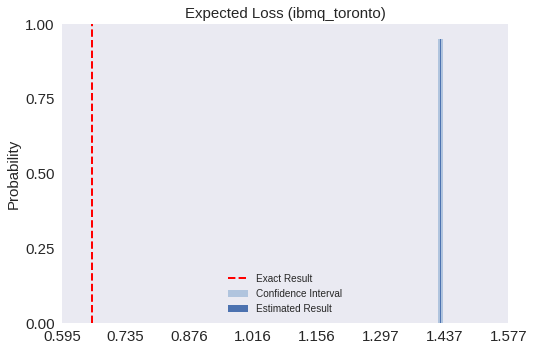

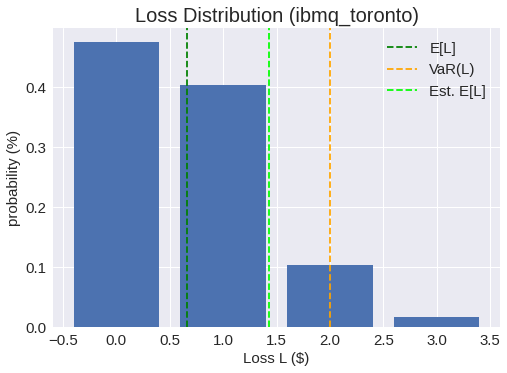

Executing mlae for CDF(0) in backend ibmq_toronto...
Executing mlae for CDF(1) in backend ibmq_toronto...
Executing mlae for CDF(2) in backend ibmq_toronto...
Executing mlae for CDF(3) in backend ibmq_toronto...
--- CDF Original values using mlae in ibmq_toronto
	 CDF(0) = 0.4874072102432616, CI: [0.48661515579895864, 0.4881992646875646]
	 CDF(1) = 0.49358150402108614, CI: [0.4927892635359077, 0.4943737445062646]
	 CDF(2) = 0.48909429323194054, CI: [0.4883021759499937, 0.48988641051388737]
	 CDF(3) = 0.49401899395655746, CI: [0.49322674487474266, 0.49481124303837226]
--- CDF Kolmogorov-Smirnov test using mlae ----
Delta value: 0.48982
P-value (alpha = 0.0500): 0.38301


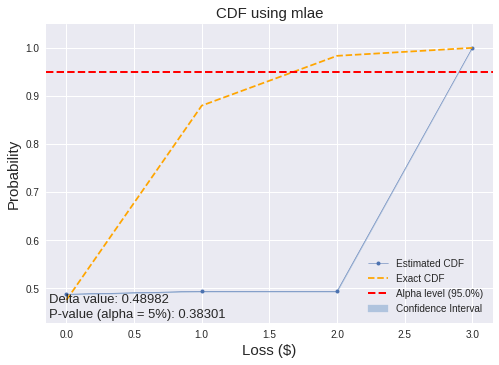


--------------------------------------------------------------------
start bisection search for target value 0.950
--------------------------------------------------------------------
low_level    low_value    level    value    high_level    high_value
--------------------------------------------------------------------
Executing mlae for CDF(1) in backend ibmq_toronto...
-1           0.000         1       0.493     3            1.000
Executing mlae for CDF(2) in backend ibmq_toronto...
 1           0.493         2       0.488     3            1.000
--------------------------------------------------------------------
finished bisection search
--------------------------------------------------------------------

----- RESULTS OF MLAE FOR VaR IN "ibmq_toronto" -----
Estimated Value at Risk:  3
Exact Value at Risk:      2
Estimated Probability:    1.00000000
Exact Probability:        0.98339844


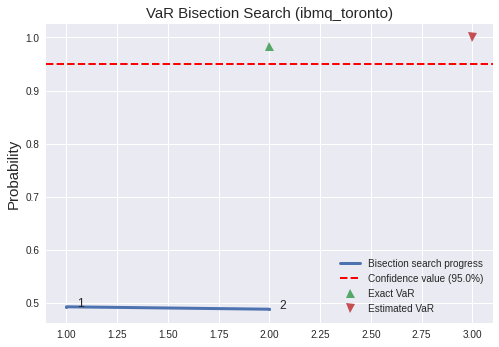

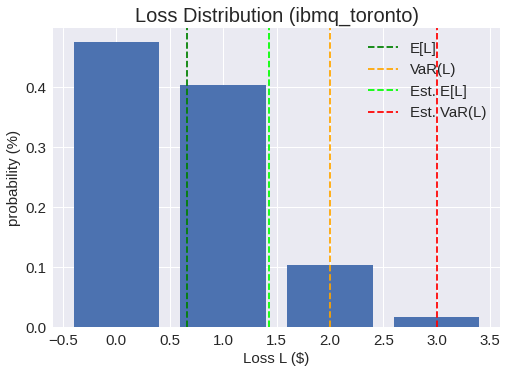

In [5]:
#cra = CreditRiskAnalysis(p_zeros,rhos,lgd,backend=backend,epsilon=0.05,alpha=0.05,shots=2048)

#p_zeros = [0.25, 0.1,0.3,0.2,0.15]
#rhos = [0.1, 0.15,0.15,0.2,0.25]
#lgd = [3,4,1,2,3]

p_zeros = [0.25, 0.1,0.15]
rhos = [0.1, 0.15,0.2]
lgd = [1,1,1]

cra = CreditRiskAnalysis(p_zeros,rhos,lgd,backend=backend,ae_algorithm = 'mlae', num_ml_queries = 5)

cra.run_all()